## Question 5 Use S&P500 index data to implement the backtesting of a 99%/10-day Value at Risk (VaR) and report the following:

(a) The count and percentage of VaR breaches.

(b) The count and percentage of consecutive VaR breaches. Example: 1, 1, 1 indicates two consecutive occurrences.

(c) Provide a plot that identifies the breaches visually, with crosses or other marks.

$$VaR_{10D,t} = \text{Factor} \times \sigma_t \times \sqrt{10}$$

- Compute the rolling standard deviation $\sigma_t$ from 21 daily returns.

- Timescale of $\sigma_t$ remains "daily" regardless of how many returns are in the sample. To make a 10-day projection, use the additivity of variance: $\sigma_{10D} = \sqrt{\sigma_t^2 \times 10}$

- A breach occurs when the forward realized 10-day return is below the $\text{VaR}_t$ quantity ($r_{10D,t+10} < VaR_{10D,t}$ means breach, given both numbers are negative)

VaR is fixed at time $t$ and compared to the return realized from $t$ to $t+10$, computed $\ln(S_{t+10}/S_t)$.  Alternatively, you can compare it to $\ln(S_{t+11}/S_{t+1})$ but state this assumption in your report upfront.


<br>

***

<br>

**Step 1: Data acquisition**

First, we need to obtain historical daily closing prices for the S&P500 index.

We can use the yfinance library in Python to download the data:

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Data Acquisition
start_date = '2010-01-01'
end_date = '2024-12-22'
data = yf.download('^GSPC', start=start_date, end=end_date, auto_adjust=True)

# Check if data is downloaded correctly
print(data.head())
print(data.columns)

[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2010-01-04  1132.989990  1133.869995  1116.560059  1116.560059  3991400000
2010-01-05  1136.520020  1136.630005  1129.660034  1132.660034  2491020000
2010-01-06  1137.140015  1139.189941  1133.949951  1135.709961  4972660000
2010-01-07  1141.689941  1142.459961  1131.319946  1136.270020  5270680000
2010-01-08  1144.979980  1145.390015  1136.219971  1140.520020  4389590000
MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])


In [2]:
# Flatten the MultiIndex columns if necessary
if isinstance(data.columns, pd.MultiIndex):
    # Drop the second level (ticker symbol)
    data.columns = data.columns.get_level_values(0)

# Now, data.columns should be single-level
print(data.columns)

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


<br>

***

<br>

**Step 2: Calculate daily logarithmic returns**

Compute the daily logarithmic returns of the adjusted closing prices:

In [3]:
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))

<br>

***

<br>

**Step 3: Compute rolling standard deviation ($\sigma_t$)**

Calculate the rolling standard deviation over a 21-day window:

In [4]:
window_size = 21  # 21 trading days ~1 month
data['Sigma_t'] = data['Log_Return'].rolling(window=window_size).std()

<br>

***

<br>

**Step 4: Calculate the 99% VaR factor**

For a 99% confidence level, the z-score from the standard normal distribution is:

In [5]:
confidence_level = 0.99
VaR_factor = norm.ppf(1 - confidence_level)  # Negative value since it's in the left tail

- The norm.ppf function gives the quantile function (inverse of the cumulative distribution function) for the standard normal distribution.

- At 99% confidence, VaR_factor will be approximately -2.326.

<br>

***

<br>

**Step 5: Calculate the 10-Day VaR ($VaR_{10D,t}$)**

Use the given formula:

$$VaR_{10D,t} = \text{Factor} \times \sigma_t \times \sqrt{10}$$

Compute the 10-day VaR:

In [6]:
data['VaR_10D_t'] = VaR_factor * data['Sigma_t'] * np.sqrt(10)


<br>

***

<br>

**Step 6: Calculate the realized 10-day forward return**

Compute the realized 10-day forward logarithmic return:

In [7]:
# Realized 10-day forward log return
data['Realized_10D_Return'] = np.log(data['Close'].shift(-10) / data['Close'])

This calculates $\ln(S_{t+10}/S_t)$ as specified 

<br>

***

<br>

**Step 7: Identify VaR breaches**

A breach occurs when the realized 10-day return is less than the VaR at time t:

In [8]:
data['Breach'] = data['Realized_10D_Return'] < data['VaR_10D_t']

- Both Realized_10D_Return and VaR_10D_t are negative numbers.

- data['Breach'] is a Boolean series where True indicates a breach.

<br>

***

<br>

**Step 8: Count and percentage of var breaches (answering question (a) the count and percentage of VaR breaches)**

Calculate the total number of breaches and the percentage:

In [9]:
# Drop NaN values to ensure accurate counts
breach_data = data.dropna(subset=['Realized_10D_Return', 'VaR_10D_t'])

total_breaches = breach_data['Breach'].sum()
total_observations = len(breach_data)
breach_percentage = (total_breaches / total_observations) * 100

print(f"Total VaR Breaches: {total_breaches}")
print(f"Percentage of VaR Breaches: {breach_percentage:.2f}%")

Total VaR Breaches: 99
Percentage of VaR Breaches: 2.65%



<br>

***

<br>

**Step 9: Count and percentage of consecutive var breaches (answering question (b) the count and percentage of consecutive VaR breaches. Example: 1, 1, 1 indicates two consecutive occurrences)**

Identify consecutive breaches:

In [10]:
# Identify consecutive breaches
breach_data = data.dropna(subset=['Realized_10D_Return', 'VaR_10D_t']).copy()
breach_data['Consecutive_Breach'] = (breach_data['Breach'] & breach_data['Breach'].shift(1)).fillna(False)

# Count consecutive breaches
total_consecutive_breaches = breach_data['Consecutive_Breach'].sum()
consecutive_breach_percentage = (total_consecutive_breaches / total_observations) * 100

print(f"Total Consecutive VaR Breaches: {total_consecutive_breaches}")
print(f"Percentage of Consecutive VaR Breaches: {consecutive_breach_percentage:.2f}%")

Total Consecutive VaR Breaches: 63
Percentage of Consecutive VaR Breaches: 1.69%


- Here, a consecutive breach is counted when a breach occurs and the previous day was also a breach.

<br>

***

<br>

**Step 10: Plot the breaches (answering question (c) provide a plot that identifies the breaches visually, with crosses or other marks)**

Create a plot that identifies the breaches visually:

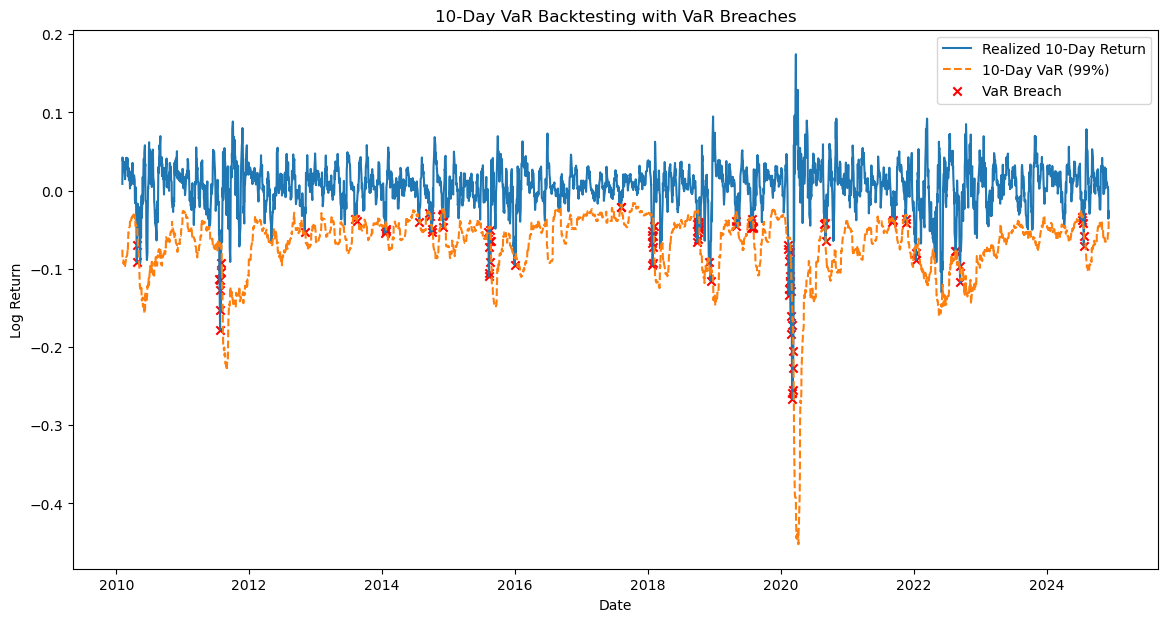

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.plot(breach_data.index, breach_data['Realized_10D_Return'], label='Realized 10-Day Return')
plt.plot(breach_data.index, breach_data['VaR_10D_t'], label='10-Day VaR (99%)', linestyle='--')

# Mark breaches with red crosses
breach_dates = breach_data[breach_data['Breach']].index
breach_returns = breach_data[breach_data['Breach']]['Realized_10D_Return']
plt.scatter(breach_dates, breach_returns, color='red', marker='x', label='VaR Breach')

plt.title('10-Day VaR Backtesting with VaR Breaches')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.show()

- The plot shows the realized 10-day returns and the VaR threshold.

- Breaches are marked with red crosses.

<br>

**Assumptions**

- Realized Return Calculation: We used $\ln(S_{t+10}/S_t)$ for the forward realized 10-day return, as specified.

- Normality of Returns: We assumed that returns are normally distributed, which is standard in VaR calculations.

- Rolling Window: The rolling standard deviation uses a 21-day window to estimate daily volatility.

- Data Frequency: All calculations are based on daily data.

<br>

**Interpretation**

- Expected Breach Percentage: With a 99% VaR, we expect about 1% of the observations to breach the VaR threshold.

- Actual Breach Percentage: Compare the calculated breach percentage to 1% to assess the model's accuracy.

    - Higher Breach Percentage: Indicates the VaR model may underestimate risk.

    - Lower Breach Percentage: Suggests the model may be too conservative.

<br>

**Conclusion**

By implementing the above steps, we've successfully:

- Calculated the number and percentage of VaR breaches.

- Identified consecutive breaches and computed their count and percentage.

- Visualized the breaches in a plot, marking them for easy identification.

- This backtesting approach helps in evaluating the effectiveness of the VaR model for risk management purposes.

<br>

**Observation**

- Breach Percentage vs. 99% VaR

    - If the model was perfectly calibrated to normal assumptions, we would expect ~1% breaches at a 99% VaR.

    - Observing ~2.65% breaches suggests the market experienced heavier downside tail events or higher volatility clusters than the simple normal model predicts.

- Consecutive Breaches

    - Around 1.69% of all observations being part of a consecutive breach might be plausible, especially if we think about crisis periods in 2020–2023.

    - Consecutive breaches typically cluster during prolonged drawdowns (e.g., COVID crash).